##### This notebook is dedicated towards the case study for Pair Finance email delivering service. The problem statement is to optimize the responsiveness of the users. 
The work is divided in following sections
    1. Data processing for user level summarization
    2. Define the logic for assigning user behavior for mail reverts. i.e. define the time window as the user affinity
        2.1 Rules for defining affinity for a person. This is funnel approach, so users are tagged on successive iterations.
        2.2 Combine rule for the different types of users
    3. Building data pipeline for data processing
    4. Modeling with XGBoost regressor
    5. Result analysis
    6. Package creation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip install jupyterthemes
!jt -t onedork

In [3]:
# Read the data
raw_data = pd.read_csv("/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/data/data.csv",
                                na_values = ['NA', 'na', 'nan', 'NaN', 'Nan', np.nan, np.inf, 'missing', 'NULL', 'null', 'Null', None, 
                                            'None', 'none', ' ', ''],
                                low_memory=False
                               )

In [4]:
raw_data.head()

,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,17:00,11:58,11:00,07:47,18:00,21:27,14:00,09:57,19:00,20:13,14:00,19:39,18:00,15:42,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,NaN,NaN
1,-0.14,-3.21,0,1,17:00,17:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.23,0.08,3,1,19:00,09:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,10:00,11:43,14:00,19:42,08:00,18:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(raw_data.shape)
print(raw_data.X3.value_counts(dropna=False))

(100000, 34)
0    25458
3    24904
2    24890
1    24748
Name: X3, dtype: int64


In [6]:
## Add id column to the data
raw_data['id'] = list(range(1,len(raw_data)+1))
x = raw_data.columns.tolist()
x.remove('id')
raw_data = raw_data[['id']+x]
raw_data.head()

,id,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,1,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,17:00,11:58,11:00,07:47,18:00,21:27,14:00,09:57,19:00,20:13,14:00,19:39,18:00,15:42,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,NaN,NaN
1,2,-0.14,-3.21,0,1,17:00,17:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.23,0.08,3,1,19:00,09:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,10:00,11:43,14:00,19:42,08:00,18:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 1. Data processing for user level summarization

In [7]:
# ## Restructure the data
# raw_data_restructure = pd.DataFrame()
# for i in range(1,len(raw_data)+1):
#     print(i)
#     temp_df = raw_data[raw_data.id==i].copy()
#     temp_df = temp_df.dropna(axis='columns')
#     user_profile = temp_df[['id','X1','X2','X3','M']].copy()
#     email_usage = temp_df.iloc[:,5:]
#     for j in range(0,user_profile['M'].values[0]*2,2):
#         temp_df_2 = pd.concat([user_profile, email_usage.iloc[:,j:j+2]],axis=1)
#         temp_df_2.columns = ['id','X1','X2','X3','M', 'TS', 'TO']
#         raw_data_restructure = pd.concat([raw_data_restructure,temp_df_2], axis=0)
#     if i/1000 in list(range(1,101,1)):
#         file = "/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/data/processed/raw_data_restructure_"+str(i/1000)+".csv"
#         raw_data_restructure.to_csv(file
#                                , index=False
#                               )
#         raw_data_restructure = pd.DataFrame()

##### 2. Define the logic for assigning user behavior for mail reverts. i.e. define the time window as the user affinity

In [8]:
## Read and join all the single files
import glob

directoryPath = "/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/data/processed/"
raw_data_restructure = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.csv'):
    x = pd.read_csv(file_name, na_values = ['NA', 'na', 'nan', 'NaN', 'Nan', np.nan, np.inf, 'missing', 'NULL', 'null', 'Null', None, 
                                            'None', 'none', ' ', ''],
                                low_memory=False)
    raw_data_restructure = pd.concat([raw_data_restructure,x],axis=0)
    

In [9]:
print(raw_data_restructure.shape)
print(raw_data_restructure.id.nunique())

(798960, 7)
100000


In [10]:
raw_data_restructure.head()

,id,X1,X2,X3,M,TS,TO
0,55001,-0.97,-1.16,0,2,08:00,08:43
1,55001,-0.97,-1.16,0,2,14:00,14:16
2,55002,0.83,-0.29,1,13,15:00,07:13
3,55002,0.83,-0.29,1,13,12:00,11:20
4,55002,0.83,-0.29,1,13,09:00,19:03


In [11]:
from pairfinance.helper_functions.utils import timing_of_reply
raw_data_restructure['opening_timing'] = raw_data_restructure['TO'].map(lambda x: timing_of_reply(x))

In [12]:
# raw_data_restructure['time_taken'] = time_calculate(raw_data_restructure['TS'], raw_data_restructure['TO'])
raw_data_restructure['hour_TS'] = raw_data_restructure['TS'].map(lambda x:int(x.split(':')[0]))
raw_data_restructure['hour_TO'] = raw_data_restructure['TO'].map(lambda x:int(x.split(':')[0]))

raw_data_restructure['date_TS'] = np.where(raw_data_restructure.hour_TS>raw_data_restructure.hour_TO, 
                                            pd.to_datetime(raw_data_restructure.TS) + pd.Timedelta(days=-1),
                                            pd.to_datetime(raw_data_restructure.TS)
                                           )
# Remove some rows with negative minute values
raw_data_restructure['minute_TO'] = raw_data_restructure['TO'].apply(lambda x: x.split(":")[1])
raw_data_restructure.minute_TO = raw_data_restructure.minute_TO.astype(int)
raw_data_restructure = raw_data_restructure[raw_data_restructure.minute_TO>=0]
raw_data_restructure = raw_data_restructure.drop(['minute_TO'], axis=1)
raw_data_restructure['date_TO'] = pd.to_datetime(raw_data_restructure['TO'])

raw_data_restructure['time_diff'] = (raw_data_restructure['date_TO'] - raw_data_restructure['date_TS']).astype('timedelta64[m]')
print(raw_data_restructure.id.nunique())
raw_data_restructure.head(10)

100000


,id,X1,X2,X3,M,TS,TO,opening_timing,hour_TS,hour_TO,date_TS,date_TO,time_diff
0,55001,-0.97,-1.16,0,2,08:00,08:43,6am to 12pm,8,8,2020-01-20 08:00:00,2020-01-20 08:43:00,43.0
1,55001,-0.97,-1.16,0,2,14:00,14:16,12pm to 18pm,14,14,2020-01-20 14:00:00,2020-01-20 14:16:00,16.0
2,55002,0.83,-0.29,1,13,15:00,07:13,6am to 12pm,15,7,2020-01-19 15:00:00,2020-01-20 07:13:00,973.0
3,55002,0.83,-0.29,1,13,12:00,11:20,6am to 12pm,12,11,2020-01-19 12:00:00,2020-01-20 11:20:00,1400.0
4,55002,0.83,-0.29,1,13,09:00,19:03,18pm to 23pm,9,19,2020-01-20 09:00:00,2020-01-20 19:03:00,603.0
5,55002,0.83,-0.29,1,13,19:00,17:55,12pm to 18pm,19,17,2020-01-19 19:00:00,2020-01-20 17:55:00,1375.0
6,55002,0.83,-0.29,1,13,12:00,13:08,12pm to 18pm,12,13,2020-01-20 12:00:00,2020-01-20 13:08:00,68.0
7,55002,0.83,-0.29,1,13,08:00,23:15,None,8,23,2020-01-20 08:00:00,2020-01-20 23:15:00,915.0
8,55002,0.83,-0.29,1,13,14:00,14:31,12pm to 18pm,14,14,2020-01-20 14:00:00,2020-01-20 14:31:00,31.0
9,55002,0.83,-0.29,1,13,14:00,18:07,18pm to 23pm,14,18,2020-01-20 14:00:00,2020-01-20 18:07:00,247.0


###### 2.1 Rules for defining affinity for a person. This is funnel approach, so users are tagged on successive iterations.
    1. Time difference always < 90 then he's an active person
    2. More than 70% emails are opened at a single time window, then assign that window.
    3. Min. of opening time with > 20% of emails opened
    4. Max. percentage of emails opened from the rest of the dataset

In [13]:
## Summarize the raw_data
raw_data_summary = raw_data_restructure[['id','X1','X2','M','opening_timing','time_diff']].groupby(['id','X1','X2','M','opening_timing']).agg(('mean','count')).reset_index()
raw_data_summary.columns = ['id', 'X1', 'X2', 'M', 'opening_timing', 'time_diff_mean', 'time_diff_count']
raw_data_summary.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1
4,3,1.23,0.08,1,6am to 12pm,862.000000,1


In [14]:
## Add percent_email columns for each row
raw_data_summary_total = raw_data_summary.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_count':'sum'}).reset_index()
raw_data_summary_merged = pd.merge(raw_data_summary,raw_data_summary_total,on=['id', 'X1', 'X2', 'M'], how='left', suffixes=('','_total'))
raw_data_summary_merged['percent_emails'] = np.round(raw_data_summary_merged['time_diff_count']/raw_data_summary_merged['time_diff_count_total'],3)
raw_data_summary_merged.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2,14,0.143
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5,14,0.357
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7,14,0.500
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000
4,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000


In [15]:
## Add mean time_diff_mean column at user level
raw_data_restructure_mean = raw_data_restructure.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff':'mean'}).reset_index()
raw_data_restructure_mean.columns = ['id', 'X1', 'X2', 'M', 'avg_opening_time']
raw_data_summary_merged = pd.merge(raw_data_summary_merged,raw_data_restructure_mean,on=['id', 'X1', 'X2', 'M'], how='left', suffixes=('',''))
print(raw_data_summary_merged.id.nunique())
raw_data_summary_merged.head(10)

99851


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2,14,0.143,934.428571
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5,14,0.357,934.428571
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7,14,0.500,934.428571
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000,11.000000
4,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000,862.000000
5,4,-0.38,-1.30,2,12pm to 18pm,38.000000,1,2,0.500,51.000000
6,4,-0.38,-1.30,2,6am to 12pm,64.000000,1,2,0.500,51.000000
7,5,-1.50,0.22,6,12pm to 18pm,361.000000,1,5,0.200,402.333333
8,5,-1.50,0.22,6,18pm to 23pm,474.333333,3,5,0.600,402.333333
9,5,-1.50,0.22,6,6am to 12pm,103.000000,1,5,0.200,402.333333


In [16]:
## Rule 1
raw_data_summary_merged['preference'] = np.where(raw_data_summary_merged.avg_opening_time<90, 'instant','unk')
rule_1 = raw_data_summary_merged[raw_data_summary_merged.preference=='instant']
print(raw_data_summary_merged[raw_data_summary_merged.preference=='instant'].id.nunique())

18230


In [17]:
## Rule 2
# Add a flag for percentage of emails
percent_emails_filter = raw_data_summary_merged[raw_data_summary_merged.preference!='instant']
xx = percent_emails_filter[percent_emails_filter.percent_emails>=0.7].id.unique()
percent_emails_filter['preference'] = np.where(percent_emails_filter.id.isin(xx),'one_time','unk')
rule_2 = percent_emails_filter[percent_emails_filter.preference=='one_time']
print(percent_emails_filter[percent_emails_filter.preference=='one_time'].id.nunique())

22566


/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
## Rule 3
rest_df = percent_emails_filter[percent_emails_filter.preference!='one_time']
rest_df_min_opening = rest_df.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_mean':'min'}).reset_index()
rest_df_joined = pd.merge(rest_df, rest_df_min_opening, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_min'))
rest_df_joined.head()
rest_df_joined['min_col'] = np.where(rest_df_joined.time_diff_mean==rest_df_joined.time_diff_mean_min,1,0)
last_df = rest_df_joined[(rest_df_joined.min_col==1) & (rest_df_joined.percent_emails>=0.2)]
xx = last_df.id.unique()
rest_df_joined['preference'] = np.where(rest_df_joined.id.isin(xx),'min_20_percent','unk')
rule_3 = rest_df_joined[rest_df_joined.preference=='min_20_percent']
print(rest_df_joined[rest_df_joined.preference=='min_20_percent'].id.nunique())

45845


In [19]:
## Rule 4 : Max number of emails timing
rule_4 = rest_df_joined[rest_df_joined.preference!='min_20_percent']
rule_4_max_percent_emails = rule_4.groupby(['id', 'X1', 'X2', 'M']).agg({'percent_emails':'max'}).reset_index()
rule_4_max_percent_emails.columns = ['id', 'X1', 'X2', 'M','percent_emails_max']
rule_4_joined = pd.merge(rule_4, rule_4_max_percent_emails, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))
rule_4_joined.head()

rule_4_joined['max_col'] = np.where(rule_4_joined.percent_emails==rule_4_joined.percent_emails_max,1,0)
remain_df = rule_4_joined[rule_4_joined.max_col==1]
xx = remain_df.id.unique()
rule_4_joined['preference'] = np.where(rule_4_joined.id.isin(xx),'remain','unk')
rule_4 = rule_4_joined
rule_4_joined.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col,percent_emails_max,max_col
0,7,1.00,0.84,12,12pm to 18pm,793.0,5,12,0.417,773.666667,remain,45.5,0,0.417,1
1,7,1.00,0.84,12,18pm to 23pm,45.5,2,12,0.167,773.666667,remain,45.5,1,0.417,0
2,7,1.00,0.84,12,6am to 12pm,1045.6,5,12,0.417,773.666667,remain,45.5,0,0.417,1
3,19,-0.77,0.27,14,0 to 6am,631.5,2,13,0.154,747.571429,remain,41.0,0,0.462,0
4,19,-0.77,0.27,14,12pm to 18pm,41.0,1,13,0.077,747.571429,remain,41.0,1,0.462,0


###### 2.2 Combine rule for the different types of users

In [20]:
## Take only one time for each user
# Rule 1
rule_1_unique = rule_1.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_mean':'min'}).reset_index()
rule_1_unique.columns = ['id', 'X1', 'X2', 'M','time_diff_min']
rule_1_unique = pd.merge(rule_1, rule_1_unique, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))

rule_1_unique['same_flag'] = np.where(rule_1_unique.time_diff_mean==rule_1_unique.time_diff_min,1,0)
rule_1_unique = rule_1_unique[rule_1_unique.same_flag==1]
print(rule_1_unique.id.nunique())
rule_1_unique.head()

18230


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_min,same_flag
0,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000,11.000000,instant,11.000000,1
1,4,-0.38,-1.30,2,12pm to 18pm,38.000000,1,2,0.500,51.000000,instant,38.000000,1
3,13,-0.60,-1.76,7,12pm to 18pm,25.666667,3,7,0.429,43.571429,instant,25.666667,1
8,15,-1.05,-0.45,6,6am to 12pm,4.000000,1,6,0.167,53.500000,instant,4.000000,1
9,21,-0.25,-0.29,1,6am to 12pm,48.000000,1,1,1.000,48.000000,instant,48.000000,1


In [21]:
# Rule 2
rule_2_unique = rule_2.groupby(['id', 'X1', 'X2', 'M']).agg({'percent_emails':'max'}).reset_index()
rule_2_unique.columns = ['id', 'X1', 'X2', 'M','percent_emails_max']
rule_2_unique = pd.merge(rule_2, rule_2_unique, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))

rule_2_unique['same_flag'] = np.where(rule_2_unique.percent_emails==rule_2_unique.percent_emails_max,1,0)
rule_2_unique = rule_2_unique[rule_2_unique.same_flag==1]
print(rule_2_unique.id.nunique())
rule_2_unique.head()

22566


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,percent_emails_max,same_flag
0,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000,862.000000,one_time,1.000,1
2,9,0.23,1.55,9,6am to 12pm,656.142857,7,9,0.778,655.111111,one_time,0.778,1
4,10,0.17,2.88,6,6am to 12pm,1136.800000,5,6,0.833,1166.000000,one_time,0.833,1
6,12,-0.42,0.03,10,6am to 12pm,664.000000,8,9,0.889,634.200000,one_time,0.889,1
9,14,0.64,1.10,14,6am to 12pm,1147.900000,10,14,0.714,917.285714,one_time,0.714,1


In [22]:
# Rule 3
rule_3_unique = rule_3[rule_3.min_col==1]
print(rule_3_unique[rule_3_unique.min_col==1].id.nunique())
rule_3_unique.head()

45845


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col
1,1,-1.25,-0.88,14,18pm to 23pm,363.0,5,14,0.357,934.428571,min_20_percent,363.0,1
5,5,-1.50,0.22,6,6am to 12pm,103.0,1,5,0.200,402.333333,min_20_percent,103.0,1
6,6,0.31,-1.96,6,12pm to 18pm,37.0,1,5,0.200,433.000000,min_20_percent,37.0,1
12,8,-0.39,-1.88,3,18pm to 23pm,434.0,2,3,0.667,660.333333,min_20_percent,434.0,1
16,11,0.61,-0.18,7,18pm to 23pm,361.0,2,6,0.333,669.857143,min_20_percent,361.0,1


In [23]:
# Rule 4
rule_4_unique = rule_4[rule_4.max_col==1]
print(rule_4_unique[rule_4_unique.max_col==1].id.nunique())
rule_4_unique.head()

13210


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col,percent_emails_max,max_col
0,7,1.00,0.84,12,12pm to 18pm,793.000000,5,12,0.417,773.666667,remain,45.5,0,0.417,1
2,7,1.00,0.84,12,6am to 12pm,1045.600000,5,12,0.417,773.666667,remain,45.5,0,0.417,1
6,19,-0.77,0.27,14,6am to 12pm,865.333333,6,13,0.462,747.571429,remain,41.0,0,0.462,1
9,23,-0.47,3.49,15,18pm to 23pm,520.571429,7,13,0.538,771.600000,remain,333.0,0,0.538,1
13,27,2.11,-0.27,6,6am to 12pm,583.666667,3,6,0.500,450.000000,remain,283.0,0,0.500,1


In [24]:
## Merge with the raw_data_restructure
final_data = raw_data_restructure.copy()
final_data = pd.merge(final_data, rule_1_unique[['id', 'X1', 'X2', 'M','opening_timing','same_flag']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_1'))
final_data = pd.merge(final_data, rule_2_unique[['id', 'X1', 'X2', 'M','opening_timing','same_flag']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_2'))
final_data = pd.merge(final_data, rule_3_unique[['id', 'X1', 'X2', 'M','opening_timing','min_col']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_3'))
final_data = pd.merge(final_data, rule_4_unique[['id', 'X1', 'X2', 'M','opening_timing','max_col']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_4'))
final_data = final_data.fillna(0)
final_data['keep_row'] = final_data['same_flag']+final_data['same_flag_rule_2']+final_data['min_col']+final_data['max_col']
final_data = final_data[final_data.keep_row>0]

print(final_data.shape)
print(final_data.id.nunique())
final_data.head(100)

(386876, 18)
99851


,id,X1,X2,X3,M,TS,TO,opening_timing,hour_TS,hour_TO,date_TS,date_TO,time_diff,same_flag,same_flag_rule_2,min_col,max_col,keep_row
1,55001,-0.97,-1.16,0,2,14:00,14:16,12pm to 18pm,14,14,2020-01-20 14:00:00,2020-01-20 14:16:00,16.0,1.0,0.0,0.0,0.0,1.0
5,55002,0.83,-0.29,1,13,19:00,17:55,12pm to 18pm,19,17,2020-01-19 19:00:00,2020-01-20 17:55:00,1375.0,0.0,0.0,1.0,0.0,1.0
6,55002,0.83,-0.29,1,13,12:00,13:08,12pm to 18pm,12,13,2020-01-20 12:00:00,2020-01-20 13:08:00,68.0,0.0,0.0,1.0,0.0,1.0
8,55002,0.83,-0.29,1,13,14:00,14:31,12pm to 18pm,14,14,2020-01-20 14:00:00,2020-01-20 14:31:00,31.0,0.0,0.0,1.0,0.0,1.0
12,55002,0.83,-0.29,1,13,10:00,14:45,12pm to 18pm,10,14,2020-01-20 10:00:00,2020-01-20 14:45:00,285.0,0.0,0.0,1.0,0.0,1.0
16,55003,-0.42,-0.14,3,7,20:00,21:23,18pm to 23pm,20,21,2020-01-20 20:00:00,2020-01-20 21:23:00,83.0,0.0,0.0,1.0,0.0,1.0
20,55003,-0.42,-0.14,3,7,20:00,20:01,18pm to 23pm,20,20,2020-01-20 20:00:00,2020-01-20 20:01:00,1.0,0.0,0.0,1.0,0.0,1.0
22,55004,0.26,0.79,1,3,20:00,09:19,6am to 12pm,20,9,2020-01-19 20:00:00,2020-01-20 09:19:00,799.0,0.0,1.0,0.0,0.0,1.0
23,55004,0.26,0.79,1,3,12:00,08:33,6am to 12pm,12,8,2020-01-19 12:00:00,2020-01-20 08:33:00,1233.0,0.0,1.0,0.0,0.0,1.0
24,55004,0.26,0.79,1,3,11:00,09:47,6am to 12pm,11,9,2020-01-19 11:00:00,2020-01-20 09:47:00,1367.0,0.0,1.0,0.0,0.0,1.0


In [25]:
final_data['TO_minute'] = final_data['TO'].apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))
final_data = final_data.groupby(['id', 'X1', 'X2','X3']).agg({'TO_minute':'mean'}).reset_index()
final_data.head()

,id,X1,X2,X3,TO_minute
0,1,-1.25,-0.88,2,1263.0
1,2,-0.14,-3.21,0,1031.0
2,3,1.23,0.08,3,562.0
3,4,-0.38,-1.30,3,758.0
4,5,-1.50,0.22,2,703.0


In [26]:
from sklearn.model_selection import train_test_split
np.random.seed(123)

y_data_modeling = final_data[['TO_minute']]
# final_data = final_data.drop(['TO_minute'],axis=1)

train_data_modeling, val_data_modeling, y_train_data_modeling, y_val_data_modeling = train_test_split(final_data, y_data_modeling, test_size=0.20, random_state=123)
val_data_modeling, test_data_modeling, y_val_data_modeling, y_test_data_modeling = train_test_split(val_data_modeling, y_val_data_modeling, test_size=0.50, random_state=123)
print(final_data.shape)
print(train_data_modeling.shape)
print(y_train_data_modeling.shape)
print(val_data_modeling.shape)
print(y_val_data_modeling.shape)
print(test_data_modeling.shape)
print(y_test_data_modeling.shape)


(99851, 5)
(79880, 5)
(79880, 1)
(9985, 5)
(9985, 1)
(9986, 5)
(9986, 1)


##### 3. Building data pipeline for data processing

In [27]:
## Define columns 
selected_columns = ['id','X1','X2','X3']
numerical_columns = ['X1','X2']
low_cardinal_columns_before = ['X3']
low_cardinal_columns_after = pd.get_dummies(final_data[['X3']].fillna('unk').astype('str')).columns.tolist()

In [28]:
## Data pipeline building
from pairfinance.data_processing.pipeline import get_preprocess_pipeline

train_pipeline = get_preprocess_pipeline(selected_columns=selected_columns,
                                         numerical_columns=numerical_columns,
                                         strategy='median',
                                         low_card_columns_before=low_cardinal_columns_before,
                                         low_card_columns_after=low_cardinal_columns_after
                                        )

train_pipeline.fit_transform(train_data_modeling)

new_numerical_columns = train_pipeline.steps[1][1].transformer_list[0][1].steps[5][1].get_feature_names()
new_low_card_columns = train_pipeline.steps[1][1].transformer_list[1][1].steps[3][1].get_feature_names()

all_new_columns = new_numerical_columns + new_low_card_columns


In [29]:
import time
train_data_modeling_transformed = train_pipeline.transform(train_data_modeling)
val_data_modeling_transformed = train_pipeline.transform(val_data_modeling)
test_data_modeling_transformed= train_pipeline.transform(test_data_modeling)

print(train_data_modeling_transformed.shape)
print(val_data_modeling_transformed.shape)
print(test_data_modeling_transformed.shape)

t1 = time.time()
train_pipeline.transform(train_data_modeling.head(1))
t2 = time.time()
print('Time taken = {}s'.format(t2 - t1))

(79880, 6)
(9985, 6)
(9986, 6)
Time taken = 0.018571138381958008s


##### 4. Modeling using XGBoost

In [46]:
import xgboost as xgb
np.random.seed(123)

# XGBoost model run
n=2000
xgb_model = xgb.XGBRegressor(max_depth=4,
                             learning_rate=0.001,
                             n_estimators=n,
                             verbosity=1,
                             objective='reg:squarederror', # reg:linear reg:squarederror
                             booster='gbtree', # gblinear gbtree
                             tree_method='auto',
                             n_jobs=1,
                             gamma=3,
                             min_child_weight=0,
                             max_delta_step=0,
                             subsample=0.7,
                             colsample_bytree=0.6,
                             colsample_bylevel=1,
                             colsample_bynode=1,
                             reg_alpha=3,
                             reg_lambda=5,
                             scale_pos_weight=1,
                             random_state=123,
                             missing=None,
                             num_parallel_tree=1,
                             importance_type='gain'
                            )

xgb_model.fit(train_data_modeling_transformed, y_train_data_modeling.values,
              eval_set=[(train_data_modeling_transformed, y_train_data_modeling.values), (val_data_modeling_transformed, y_val_data_modeling.values)],
#               sample_weight = weight_array,
              eval_metric=['mae', 'rmse'],
              verbose=True
             )

evals_result = xgb_model.evals_result()

[0]	validation_0-mae:879.956	validation_0-rmse:927.815	validation_1-mae:878.554	validation_1-rmse:925.932
[1]	validation_0-mae:879.021	validation_0-rmse:926.971	validation_1-mae:877.693	validation_1-rmse:925.089
[2]	validation_0-mae:878.229	validation_0-rmse:926.127	validation_1-mae:876.794	validation_1-rmse:924.246
[3]	validation_0-mae:877.307	validation_0-rmse:925.296	validation_1-mae:875.941	validation_1-rmse:923.413
[4]	validation_0-mae:876.423	validation_0-rmse:924.455	validation_1-mae:875.063	validation_1-rmse:922.57
[5]	validation_0-mae:875.508	validation_0-rmse:923.624	validation_1-mae:874.17	validation_1-rmse:921.738
[6]	validation_0-mae:874.651	validation_0-rmse:922.79	validation_1-mae:873.318	validation_1-rmse:920.907
[7]	validation_0-mae:873.808	validation_0-rmse:921.965	validation_1-mae:872.439	validation_1-rmse:920.076
[8]	validation_0-mae:872.948	validation_0-rmse:921.122	validation_1-mae:871.564	validation_1-rmse:919.23
[9]	validation_0-mae:872.103	validation_0-rmse:920

[78]	validation_0-mae:814.294	validation_0-rmse:864.884	validation_1-mae:812.831	validation_1-rmse:862.935
[79]	validation_0-mae:813.45	validation_0-rmse:864.114	validation_1-mae:812.044	validation_1-rmse:862.167
[80]	validation_0-mae:812.643	validation_0-rmse:863.334	validation_1-mae:811.235	validation_1-rmse:861.383
[81]	validation_0-mae:811.831	validation_0-rmse:862.559	validation_1-mae:810.432	validation_1-rmse:860.609
[82]	validation_0-mae:811.043	validation_0-rmse:861.798	validation_1-mae:809.624	validation_1-rmse:859.844
[83]	validation_0-mae:810.2	validation_0-rmse:861.033	validation_1-mae:808.831	validation_1-rmse:859.078
[84]	validation_0-mae:809.447	validation_0-rmse:860.272	validation_1-mae:808.011	validation_1-rmse:858.316
[85]	validation_0-mae:808.639	validation_0-rmse:859.498	validation_1-mae:807.223	validation_1-rmse:857.547
[86]	validation_0-mae:807.83	validation_0-rmse:858.73	validation_1-mae:806.407	validation_1-rmse:856.776
[87]	validation_0-mae:807.011	validation_0

[155]	validation_0-mae:754.579	validation_0-rmse:807.724	validation_1-mae:753.115	validation_1-rmse:805.707
[156]	validation_0-mae:753.862	validation_0-rmse:807.014	validation_1-mae:752.365	validation_1-rmse:805.003
[157]	validation_0-mae:753.084	validation_0-rmse:806.299	validation_1-mae:751.635	validation_1-rmse:804.281
[158]	validation_0-mae:752.363	validation_0-rmse:805.581	validation_1-mae:750.885	validation_1-rmse:803.562
[159]	validation_0-mae:751.651	validation_0-rmse:804.881	validation_1-mae:750.129	validation_1-rmse:802.86
[160]	validation_0-mae:750.872	validation_0-rmse:804.172	validation_1-mae:749.401	validation_1-rmse:802.15
[161]	validation_0-mae:750.154	validation_0-rmse:803.471	validation_1-mae:748.657	validation_1-rmse:801.45
[162]	validation_0-mae:749.389	validation_0-rmse:802.773	validation_1-mae:747.923	validation_1-rmse:800.751
[163]	validation_0-mae:748.647	validation_0-rmse:802.064	validation_1-mae:747.183	validation_1-rmse:800.045
[164]	validation_0-mae:747.919	

[232]	validation_0-mae:699.382	validation_0-rmse:755.395	validation_1-mae:697.876	validation_1-rmse:753.325
[233]	validation_0-mae:698.731	validation_0-rmse:754.728	validation_1-mae:697.186	validation_1-rmse:752.662
[234]	validation_0-mae:698.027	validation_0-rmse:754.086	validation_1-mae:696.485	validation_1-rmse:752.017
[235]	validation_0-mae:697.322	validation_0-rmse:753.429	validation_1-mae:695.805	validation_1-rmse:751.353
[236]	validation_0-mae:696.647	validation_0-rmse:752.785	validation_1-mae:695.125	validation_1-rmse:750.71
[237]	validation_0-mae:695.979	validation_0-rmse:752.122	validation_1-mae:694.427	validation_1-rmse:750.049
[238]	validation_0-mae:695.265	validation_0-rmse:751.481	validation_1-mae:693.755	validation_1-rmse:749.407
[239]	validation_0-mae:694.629	validation_0-rmse:750.839	validation_1-mae:693.06	validation_1-rmse:748.766
[240]	validation_0-mae:693.9	validation_0-rmse:750.182	validation_1-mae:692.371	validation_1-rmse:748.106
[241]	validation_0-mae:693.241	v

[309]	validation_0-mae:648.345	validation_0-rmse:707.296	validation_1-mae:646.751	validation_1-rmse:705.169
[310]	validation_0-mae:647.709	validation_0-rmse:706.696	validation_1-mae:646.086	validation_1-rmse:704.571
[311]	validation_0-mae:647.067	validation_0-rmse:706.103	validation_1-mae:645.458	validation_1-rmse:703.978
[312]	validation_0-mae:646.43	validation_0-rmse:705.497	validation_1-mae:644.82	validation_1-rmse:703.37
[313]	validation_0-mae:645.786	validation_0-rmse:704.908	validation_1-mae:644.183	validation_1-rmse:702.781
[314]	validation_0-mae:645.149	validation_0-rmse:704.323	validation_1-mae:643.547	validation_1-rmse:702.191
[315]	validation_0-mae:644.539	validation_0-rmse:703.732	validation_1-mae:642.912	validation_1-rmse:701.604
[316]	validation_0-mae:643.878	validation_0-rmse:703.143	validation_1-mae:642.272	validation_1-rmse:701.016
[317]	validation_0-mae:643.247	validation_0-rmse:702.557	validation_1-mae:641.641	validation_1-rmse:700.43
[318]	validation_0-mae:642.613	v

[386]	validation_0-mae:601.068	validation_0-rmse:663.39	validation_1-mae:599.414	validation_1-rmse:661.217
[387]	validation_0-mae:600.507	validation_0-rmse:662.843	validation_1-mae:598.823	validation_1-rmse:660.669
[388]	validation_0-mae:599.918	validation_0-rmse:662.286	validation_1-mae:598.227	validation_1-rmse:660.111
[389]	validation_0-mae:599.29	validation_0-rmse:661.73	validation_1-mae:597.64	validation_1-rmse:659.551
[390]	validation_0-mae:598.749	validation_0-rmse:661.17	validation_1-mae:597.048	validation_1-rmse:658.995
[391]	validation_0-mae:598.138	validation_0-rmse:660.63	validation_1-mae:596.463	validation_1-rmse:658.456
[392]	validation_0-mae:597.54	validation_0-rmse:660.078	validation_1-mae:595.868	validation_1-rmse:657.899
[393]	validation_0-mae:596.977	validation_0-rmse:659.523	validation_1-mae:595.276	validation_1-rmse:657.344
[394]	validation_0-mae:596.403	validation_0-rmse:658.983	validation_1-mae:594.695	validation_1-rmse:656.801
[395]	validation_0-mae:595.807	vali

[463]	validation_0-mae:557.34	validation_0-rmse:623.031	validation_1-mae:555.596	validation_1-rmse:620.809
[464]	validation_0-mae:556.806	validation_0-rmse:622.539	validation_1-mae:555.037	validation_1-rmse:620.315
[465]	validation_0-mae:556.274	validation_0-rmse:622.048	validation_1-mae:554.502	validation_1-rmse:619.823
[466]	validation_0-mae:555.733	validation_0-rmse:621.55	validation_1-mae:553.949	validation_1-rmse:619.323
[467]	validation_0-mae:555.181	validation_0-rmse:621.041	validation_1-mae:553.408	validation_1-rmse:618.813
[468]	validation_0-mae:554.632	validation_0-rmse:620.546	validation_1-mae:552.865	validation_1-rmse:618.321
[469]	validation_0-mae:554.074	validation_0-rmse:620.058	validation_1-mae:552.328	validation_1-rmse:617.83
[470]	validation_0-mae:553.53	validation_0-rmse:619.56	validation_1-mae:551.783	validation_1-rmse:617.333
[471]	validation_0-mae:552.982	validation_0-rmse:619.072	validation_1-mae:551.24	validation_1-rmse:616.844
[472]	validation_0-mae:552.455	val

[540]	validation_0-mae:516.861	validation_0-rmse:586.263	validation_1-mae:515.058	validation_1-rmse:583.99
[541]	validation_0-mae:516.339	validation_0-rmse:585.81	validation_1-mae:514.556	validation_1-rmse:583.539
[542]	validation_0-mae:515.856	validation_0-rmse:585.362	validation_1-mae:514.05	validation_1-rmse:583.09
[543]	validation_0-mae:515.321	validation_0-rmse:584.904	validation_1-mae:513.547	validation_1-rmse:582.636
[544]	validation_0-mae:514.824	validation_0-rmse:584.451	validation_1-mae:513.044	validation_1-rmse:582.179
[545]	validation_0-mae:514.345	validation_0-rmse:583.997	validation_1-mae:512.534	validation_1-rmse:581.724
[546]	validation_0-mae:513.845	validation_0-rmse:583.544	validation_1-mae:512.024	validation_1-rmse:581.27
[547]	validation_0-mae:513.339	validation_0-rmse:583.099	validation_1-mae:511.526	validation_1-rmse:580.825
[548]	validation_0-mae:512.832	validation_0-rmse:582.654	validation_1-mae:511.024	validation_1-rmse:580.379
[549]	validation_0-mae:512.332	va

[617]	validation_0-mae:479.43	validation_0-rmse:552.88	validation_1-mae:477.599	validation_1-rmse:550.576
[618]	validation_0-mae:478.957	validation_0-rmse:552.467	validation_1-mae:477.135	validation_1-rmse:550.159
[619]	validation_0-mae:478.471	validation_0-rmse:552.058	validation_1-mae:476.669	validation_1-rmse:549.751
[620]	validation_0-mae:478.027	validation_0-rmse:551.643	validation_1-mae:476.201	validation_1-rmse:549.336
[621]	validation_0-mae:477.544	validation_0-rmse:551.227	validation_1-mae:475.736	validation_1-rmse:548.92
[622]	validation_0-mae:477.071	validation_0-rmse:550.82	validation_1-mae:475.273	validation_1-rmse:548.513
[623]	validation_0-mae:476.607	validation_0-rmse:550.415	validation_1-mae:474.811	validation_1-rmse:548.107
[624]	validation_0-mae:476.151	validation_0-rmse:550.009	validation_1-mae:474.342	validation_1-rmse:547.701
[625]	validation_0-mae:475.681	validation_0-rmse:549.595	validation_1-mae:473.88	validation_1-rmse:547.288
[626]	validation_0-mae:475.22	val

[694]	validation_0-mae:444.91	validation_0-rmse:522.465	validation_1-mae:443.115	validation_1-rmse:520.13
[695]	validation_0-mae:444.496	validation_0-rmse:522.086	validation_1-mae:442.683	validation_1-rmse:519.752
[696]	validation_0-mae:444.054	validation_0-rmse:521.699	validation_1-mae:442.259	validation_1-rmse:519.363
[697]	validation_0-mae:443.623	validation_0-rmse:521.312	validation_1-mae:441.847	validation_1-rmse:518.974
[698]	validation_0-mae:443.19	validation_0-rmse:520.922	validation_1-mae:441.41	validation_1-rmse:518.586
[699]	validation_0-mae:442.781	validation_0-rmse:520.553	validation_1-mae:440.985	validation_1-rmse:518.217
[700]	validation_0-mae:442.331	validation_0-rmse:520.176	validation_1-mae:440.564	validation_1-rmse:517.84
[701]	validation_0-mae:441.908	validation_0-rmse:519.803	validation_1-mae:440.134	validation_1-rmse:517.465
[702]	validation_0-mae:441.52	validation_0-rmse:519.436	validation_1-mae:439.709	validation_1-rmse:517.097
[703]	validation_0-mae:441.067	val

[771]	validation_0-mae:413.479	validation_0-rmse:494.806	validation_1-mae:411.696	validation_1-rmse:492.443
[772]	validation_0-mae:413.097	validation_0-rmse:494.463	validation_1-mae:411.313	validation_1-rmse:492.1
[773]	validation_0-mae:412.724	validation_0-rmse:494.13	validation_1-mae:410.928	validation_1-rmse:491.765
[774]	validation_0-mae:412.327	validation_0-rmse:493.787	validation_1-mae:410.54	validation_1-rmse:491.424
[775]	validation_0-mae:411.943	validation_0-rmse:493.433	validation_1-mae:410.156	validation_1-rmse:491.071
[776]	validation_0-mae:411.567	validation_0-rmse:493.092	validation_1-mae:409.778	validation_1-rmse:490.729
[777]	validation_0-mae:411.187	validation_0-rmse:492.74	validation_1-mae:409.391	validation_1-rmse:490.376
[778]	validation_0-mae:410.806	validation_0-rmse:492.391	validation_1-mae:409.01	validation_1-rmse:490.023
[779]	validation_0-mae:410.404	validation_0-rmse:492.039	validation_1-mae:408.623	validation_1-rmse:489.672
[780]	validation_0-mae:410.027	val

[848]	validation_0-mae:385.767	validation_0-rmse:469.739	validation_1-mae:383.916	validation_1-rmse:467.355
[849]	validation_0-mae:385.418	validation_0-rmse:469.433	validation_1-mae:383.575	validation_1-rmse:467.051
[850]	validation_0-mae:385.076	validation_0-rmse:469.133	validation_1-mae:383.246	validation_1-rmse:466.748
[851]	validation_0-mae:384.758	validation_0-rmse:468.829	validation_1-mae:382.908	validation_1-rmse:466.446
[852]	validation_0-mae:384.42	validation_0-rmse:468.527	validation_1-mae:382.58	validation_1-rmse:466.144
[853]	validation_0-mae:384.101	validation_0-rmse:468.225	validation_1-mae:382.245	validation_1-rmse:465.841
[854]	validation_0-mae:383.755	validation_0-rmse:467.924	validation_1-mae:381.917	validation_1-rmse:465.539
[855]	validation_0-mae:383.433	validation_0-rmse:467.621	validation_1-mae:381.586	validation_1-rmse:465.238
[856]	validation_0-mae:383.099	validation_0-rmse:467.32	validation_1-mae:381.259	validation_1-rmse:464.936
[857]	validation_0-mae:382.777	

[925]	validation_0-mae:362.233	validation_0-rmse:447.142	validation_1-mae:360.365	validation_1-rmse:444.747
[926]	validation_0-mae:361.966	validation_0-rmse:446.85	validation_1-mae:360.087	validation_1-rmse:444.454
[927]	validation_0-mae:361.678	validation_0-rmse:446.577	validation_1-mae:359.812	validation_1-rmse:444.18
[928]	validation_0-mae:361.41	validation_0-rmse:446.297	validation_1-mae:359.534	validation_1-rmse:443.901
[929]	validation_0-mae:361.122	validation_0-rmse:446.006	validation_1-mae:359.262	validation_1-rmse:443.609
[930]	validation_0-mae:360.851	validation_0-rmse:445.716	validation_1-mae:358.988	validation_1-rmse:443.319
[931]	validation_0-mae:360.58	validation_0-rmse:445.444	validation_1-mae:358.712	validation_1-rmse:443.047
[932]	validation_0-mae:360.311	validation_0-rmse:445.172	validation_1-mae:358.443	validation_1-rmse:442.776
[933]	validation_0-mae:360.027	validation_0-rmse:444.898	validation_1-mae:358.172	validation_1-rmse:442.5
[934]	validation_0-mae:359.766	val

[1002]	validation_0-mae:342.675	validation_0-rmse:426.825	validation_1-mae:340.898	validation_1-rmse:424.422
[1003]	validation_0-mae:342.459	validation_0-rmse:426.579	validation_1-mae:340.666	validation_1-rmse:424.175
[1004]	validation_0-mae:342.227	validation_0-rmse:426.313	validation_1-mae:340.439	validation_1-rmse:423.911
[1005]	validation_0-mae:341.983	validation_0-rmse:426.064	validation_1-mae:340.212	validation_1-rmse:423.659
[1006]	validation_0-mae:341.763	validation_0-rmse:425.819	validation_1-mae:339.979	validation_1-rmse:423.415
[1007]	validation_0-mae:341.532	validation_0-rmse:425.569	validation_1-mae:339.753	validation_1-rmse:423.165
[1008]	validation_0-mae:341.314	validation_0-rmse:425.318	validation_1-mae:339.528	validation_1-rmse:422.915
[1009]	validation_0-mae:341.075	validation_0-rmse:425.069	validation_1-mae:339.303	validation_1-rmse:422.666
[1010]	validation_0-mae:340.854	validation_0-rmse:424.826	validation_1-mae:339.075	validation_1-rmse:422.422
[1011]	validation_0

[1078]	validation_0-mae:326.655	validation_0-rmse:408.719	validation_1-mae:324.985	validation_1-rmse:406.314
[1079]	validation_0-mae:326.465	validation_0-rmse:408.499	validation_1-mae:324.794	validation_1-rmse:406.093
[1080]	validation_0-mae:326.275	validation_0-rmse:408.276	validation_1-mae:324.609	validation_1-rmse:405.87
[1081]	validation_0-mae:326.078	validation_0-rmse:408.05	validation_1-mae:324.42	validation_1-rmse:405.645
[1082]	validation_0-mae:325.9	validation_0-rmse:407.825	validation_1-mae:324.229	validation_1-rmse:405.421
[1083]	validation_0-mae:325.697	validation_0-rmse:407.606	validation_1-mae:324.045	validation_1-rmse:405.202
[1084]	validation_0-mae:325.516	validation_0-rmse:407.368	validation_1-mae:323.853	validation_1-rmse:404.964
[1085]	validation_0-mae:325.328	validation_0-rmse:407.152	validation_1-mae:323.664	validation_1-rmse:404.745
[1086]	validation_0-mae:325.13	validation_0-rmse:406.934	validation_1-mae:323.481	validation_1-rmse:404.528
[1087]	validation_0-mae:3

[1154]	validation_0-mae:313.468	validation_0-rmse:392.378	validation_1-mae:311.925	validation_1-rmse:389.976
[1155]	validation_0-mae:313.308	validation_0-rmse:392.174	validation_1-mae:311.77	validation_1-rmse:389.774
[1156]	validation_0-mae:313.159	validation_0-rmse:391.969	validation_1-mae:311.614	validation_1-rmse:389.571
[1157]	validation_0-mae:312.996	validation_0-rmse:391.754	validation_1-mae:311.454	validation_1-rmse:389.355
[1158]	validation_0-mae:312.84	validation_0-rmse:391.552	validation_1-mae:311.302	validation_1-rmse:389.152
[1159]	validation_0-mae:312.696	validation_0-rmse:391.355	validation_1-mae:311.152	validation_1-rmse:388.956
[1160]	validation_0-mae:312.544	validation_0-rmse:391.16	validation_1-mae:311.001	validation_1-rmse:388.761
[1161]	validation_0-mae:312.394	validation_0-rmse:390.965	validation_1-mae:310.852	validation_1-rmse:388.566
[1162]	validation_0-mae:312.242	validation_0-rmse:390.77	validation_1-mae:310.702	validation_1-rmse:388.371
[1163]	validation_0-mae

[1230]	validation_0-mae:302.859	validation_0-rmse:377.766	validation_1-mae:301.381	validation_1-rmse:375.377
[1231]	validation_0-mae:302.721	validation_0-rmse:377.571	validation_1-mae:301.246	validation_1-rmse:375.181
[1232]	validation_0-mae:302.599	validation_0-rmse:377.388	validation_1-mae:301.121	validation_1-rmse:375
[1233]	validation_0-mae:302.478	validation_0-rmse:377.209	validation_1-mae:300.998	validation_1-rmse:374.818
[1234]	validation_0-mae:302.352	validation_0-rmse:377.033	validation_1-mae:300.879	validation_1-rmse:374.643
[1235]	validation_0-mae:302.24	validation_0-rmse:376.858	validation_1-mae:300.76	validation_1-rmse:374.469
[1236]	validation_0-mae:302.114	validation_0-rmse:376.682	validation_1-mae:300.644	validation_1-rmse:374.293
[1237]	validation_0-mae:301.995	validation_0-rmse:376.501	validation_1-mae:300.519	validation_1-rmse:374.113
[1238]	validation_0-mae:301.869	validation_0-rmse:376.323	validation_1-mae:300.396	validation_1-rmse:373.935
[1239]	validation_0-mae:3

[1306]	validation_0-mae:294.398	validation_0-rmse:364.765	validation_1-mae:292.912	validation_1-rmse:362.394
[1307]	validation_0-mae:294.3	validation_0-rmse:364.602	validation_1-mae:292.809	validation_1-rmse:362.232
[1308]	validation_0-mae:294.2	validation_0-rmse:364.446	validation_1-mae:292.713	validation_1-rmse:362.075
[1309]	validation_0-mae:294.102	validation_0-rmse:364.283	validation_1-mae:292.611	validation_1-rmse:361.914
[1310]	validation_0-mae:294.007	validation_0-rmse:364.129	validation_1-mae:292.517	validation_1-rmse:361.758
[1311]	validation_0-mae:293.893	validation_0-rmse:363.954	validation_1-mae:292.405	validation_1-rmse:361.584
[1312]	validation_0-mae:293.802	validation_0-rmse:363.796	validation_1-mae:292.309	validation_1-rmse:361.428
[1313]	validation_0-mae:293.71	validation_0-rmse:363.642	validation_1-mae:292.216	validation_1-rmse:361.273
[1314]	validation_0-mae:293.599	validation_0-rmse:363.469	validation_1-mae:292.104	validation_1-rmse:361.1
[1315]	validation_0-mae:29

[1382]	validation_0-mae:287.477	validation_0-rmse:353.145	validation_1-mae:285.935	validation_1-rmse:350.797
[1383]	validation_0-mae:287.398	validation_0-rmse:353.007	validation_1-mae:285.858	validation_1-rmse:350.658
[1384]	validation_0-mae:287.328	validation_0-rmse:352.867	validation_1-mae:285.782	validation_1-rmse:350.521
[1385]	validation_0-mae:287.249	validation_0-rmse:352.731	validation_1-mae:285.707	validation_1-rmse:350.383
[1386]	validation_0-mae:287.175	validation_0-rmse:352.591	validation_1-mae:285.631	validation_1-rmse:350.244
[1387]	validation_0-mae:287.075	validation_0-rmse:352.436	validation_1-mae:285.533	validation_1-rmse:350.088
[1388]	validation_0-mae:286.976	validation_0-rmse:352.279	validation_1-mae:285.437	validation_1-rmse:349.931
[1389]	validation_0-mae:286.905	validation_0-rmse:352.142	validation_1-mae:285.361	validation_1-rmse:349.795
[1390]	validation_0-mae:286.829	validation_0-rmse:352.005	validation_1-mae:285.285	validation_1-rmse:349.657
[1391]	validation_0

[1458]	validation_0-mae:281.66	validation_0-rmse:342.818	validation_1-mae:280.117	validation_1-rmse:340.499
[1459]	validation_0-mae:281.6	validation_0-rmse:342.696	validation_1-mae:280.054	validation_1-rmse:340.377
[1460]	validation_0-mae:281.534	validation_0-rmse:342.574	validation_1-mae:279.991	validation_1-rmse:340.255
[1461]	validation_0-mae:281.471	validation_0-rmse:342.451	validation_1-mae:279.926	validation_1-rmse:340.132
[1462]	validation_0-mae:281.396	validation_0-rmse:342.322	validation_1-mae:279.855	validation_1-rmse:340.005
[1463]	validation_0-mae:281.335	validation_0-rmse:342.2	validation_1-mae:279.792	validation_1-rmse:339.882
[1464]	validation_0-mae:281.269	validation_0-rmse:342.076	validation_1-mae:279.728	validation_1-rmse:339.76
[1465]	validation_0-mae:281.196	validation_0-rmse:341.95	validation_1-mae:279.657	validation_1-rmse:339.634
[1466]	validation_0-mae:281.125	validation_0-rmse:341.824	validation_1-mae:279.585	validation_1-rmse:339.509
[1467]	validation_0-mae:28

[1534]	validation_0-mae:276.673	validation_0-rmse:333.707	validation_1-mae:275.168	validation_1-rmse:331.423
[1535]	validation_0-mae:276.594	validation_0-rmse:333.578	validation_1-mae:275.087	validation_1-rmse:331.297
[1536]	validation_0-mae:276.537	validation_0-rmse:333.47	validation_1-mae:275.034	validation_1-rmse:331.188
[1537]	validation_0-mae:276.483	validation_0-rmse:333.361	validation_1-mae:274.978	validation_1-rmse:331.08
[1538]	validation_0-mae:276.429	validation_0-rmse:333.252	validation_1-mae:274.925	validation_1-rmse:330.972
[1539]	validation_0-mae:276.374	validation_0-rmse:333.144	validation_1-mae:274.868	validation_1-rmse:330.864
[1540]	validation_0-mae:276.311	validation_0-rmse:333.033	validation_1-mae:274.806	validation_1-rmse:330.753
[1541]	validation_0-mae:276.247	validation_0-rmse:332.92	validation_1-mae:274.743	validation_1-rmse:330.641
[1542]	validation_0-mae:276.186	validation_0-rmse:332.808	validation_1-mae:274.679	validation_1-rmse:330.531
[1543]	validation_0-ma

[1610]	validation_0-mae:272.22	validation_0-rmse:325.604	validation_1-mae:270.739	validation_1-rmse:323.361
[1611]	validation_0-mae:272.172	validation_0-rmse:325.507	validation_1-mae:270.691	validation_1-rmse:323.266
[1612]	validation_0-mae:272.12	validation_0-rmse:325.411	validation_1-mae:270.643	validation_1-rmse:323.171
[1613]	validation_0-mae:272.05	validation_0-rmse:325.299	validation_1-mae:270.569	validation_1-rmse:323.058
[1614]	validation_0-mae:271.999	validation_0-rmse:325.203	validation_1-mae:270.521	validation_1-rmse:322.963
[1615]	validation_0-mae:271.953	validation_0-rmse:325.108	validation_1-mae:270.472	validation_1-rmse:322.869
[1616]	validation_0-mae:271.895	validation_0-rmse:325.009	validation_1-mae:270.416	validation_1-rmse:322.77
[1617]	validation_0-mae:271.842	validation_0-rmse:324.914	validation_1-mae:270.368	validation_1-rmse:322.676
[1618]	validation_0-mae:271.796	validation_0-rmse:324.82	validation_1-mae:270.318	validation_1-rmse:322.581
[1619]	validation_0-mae:

[1686]	validation_0-mae:268.169	validation_0-rmse:318.417	validation_1-mae:266.696	validation_1-rmse:316.223
[1687]	validation_0-mae:268.101	validation_0-rmse:318.317	validation_1-mae:266.628	validation_1-rmse:316.122
[1688]	validation_0-mae:268.057	validation_0-rmse:318.234	validation_1-mae:266.585	validation_1-rmse:316.039
[1689]	validation_0-mae:268.015	validation_0-rmse:318.149	validation_1-mae:266.541	validation_1-rmse:315.956
[1690]	validation_0-mae:267.971	validation_0-rmse:318.065	validation_1-mae:266.497	validation_1-rmse:315.872
[1691]	validation_0-mae:267.928	validation_0-rmse:317.982	validation_1-mae:266.455	validation_1-rmse:315.788
[1692]	validation_0-mae:267.884	validation_0-rmse:317.897	validation_1-mae:266.411	validation_1-rmse:315.704
[1693]	validation_0-mae:267.817	validation_0-rmse:317.795	validation_1-mae:266.344	validation_1-rmse:315.604
[1694]	validation_0-mae:267.774	validation_0-rmse:317.714	validation_1-mae:266.302	validation_1-rmse:315.522
[1695]	validation_0

[1762]	validation_0-mae:264.471	validation_0-rmse:312.016	validation_1-mae:262.996	validation_1-rmse:309.869
[1763]	validation_0-mae:264.433	validation_0-rmse:311.942	validation_1-mae:262.957	validation_1-rmse:309.796
[1764]	validation_0-mae:264.39	validation_0-rmse:311.864	validation_1-mae:262.911	validation_1-rmse:309.719
[1765]	validation_0-mae:264.341	validation_0-rmse:311.787	validation_1-mae:262.864	validation_1-rmse:309.642
[1766]	validation_0-mae:264.292	validation_0-rmse:311.71	validation_1-mae:262.818	validation_1-rmse:309.565
[1767]	validation_0-mae:264.231	validation_0-rmse:311.618	validation_1-mae:262.756	validation_1-rmse:309.475
[1768]	validation_0-mae:264.183	validation_0-rmse:311.54	validation_1-mae:262.71	validation_1-rmse:309.398
[1769]	validation_0-mae:264.144	validation_0-rmse:311.469	validation_1-mae:262.671	validation_1-rmse:309.326
[1770]	validation_0-mae:264.099	validation_0-rmse:311.392	validation_1-mae:262.625	validation_1-rmse:309.25
[1771]	validation_0-mae:

[1838]	validation_0-mae:261.121	validation_0-rmse:306.379	validation_1-mae:259.668	validation_1-rmse:304.284
[1839]	validation_0-mae:261.064	validation_0-rmse:306.298	validation_1-mae:259.613	validation_1-rmse:304.204
[1840]	validation_0-mae:261.028	validation_0-rmse:306.231	validation_1-mae:259.579	validation_1-rmse:304.138
[1841]	validation_0-mae:260.985	validation_0-rmse:306.164	validation_1-mae:259.537	validation_1-rmse:304.07
[1842]	validation_0-mae:260.951	validation_0-rmse:306.098	validation_1-mae:259.503	validation_1-rmse:304.006
[1843]	validation_0-mae:260.896	validation_0-rmse:306.017	validation_1-mae:259.447	validation_1-rmse:303.926
[1844]	validation_0-mae:260.86	validation_0-rmse:305.952	validation_1-mae:259.414	validation_1-rmse:303.862
[1845]	validation_0-mae:260.803	validation_0-rmse:305.871	validation_1-mae:259.358	validation_1-rmse:303.782
[1846]	validation_0-mae:260.763	validation_0-rmse:305.804	validation_1-mae:259.318	validation_1-rmse:303.716
[1847]	validation_0-m

[1914]	validation_0-mae:258.03	validation_0-rmse:301.333	validation_1-mae:256.619	validation_1-rmse:299.298
[1915]	validation_0-mae:257.998	validation_0-rmse:301.275	validation_1-mae:256.588	validation_1-rmse:299.241
[1916]	validation_0-mae:257.968	validation_0-rmse:301.217	validation_1-mae:256.558	validation_1-rmse:299.185
[1917]	validation_0-mae:257.936	validation_0-rmse:301.16	validation_1-mae:256.527	validation_1-rmse:299.129
[1918]	validation_0-mae:257.905	validation_0-rmse:301.104	validation_1-mae:256.497	validation_1-rmse:299.073
[1919]	validation_0-mae:257.853	validation_0-rmse:301.032	validation_1-mae:256.445	validation_1-rmse:299.001
[1920]	validation_0-mae:257.823	validation_0-rmse:300.975	validation_1-mae:256.416	validation_1-rmse:298.945
[1921]	validation_0-mae:257.785	validation_0-rmse:300.917	validation_1-mae:256.378	validation_1-rmse:298.887
[1922]	validation_0-mae:257.735	validation_0-rmse:300.845	validation_1-mae:256.327	validation_1-rmse:298.816
[1923]	validation_0-m

[1990]	validation_0-mae:255.436	validation_0-rmse:297.046	validation_1-mae:254.05	validation_1-rmse:295.067
[1991]	validation_0-mae:255.407	validation_0-rmse:296.994	validation_1-mae:254.023	validation_1-rmse:295.017
[1992]	validation_0-mae:255.374	validation_0-rmse:296.943	validation_1-mae:253.989	validation_1-rmse:294.965
[1993]	validation_0-mae:255.34	validation_0-rmse:296.89	validation_1-mae:253.955	validation_1-rmse:294.913
[1994]	validation_0-mae:255.314	validation_0-rmse:296.842	validation_1-mae:253.928	validation_1-rmse:294.865
[1995]	validation_0-mae:255.28	validation_0-rmse:296.789	validation_1-mae:253.894	validation_1-rmse:294.813
[1996]	validation_0-mae:255.253	validation_0-rmse:296.74	validation_1-mae:253.868	validation_1-rmse:294.766
[1997]	validation_0-mae:255.219	validation_0-rmse:296.69	validation_1-mae:253.833	validation_1-rmse:294.714
[1998]	validation_0-mae:255.172	validation_0-rmse:296.625	validation_1-mae:253.788	validation_1-rmse:294.651
[1999]	validation_0-mae:2

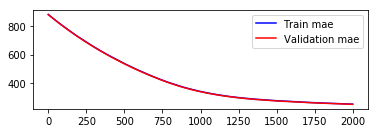

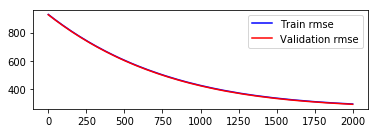

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf()
plt.subplot(211)
x=list(range(n))
plt.plot(x, evals_result['validation_0']['mae'], color='b', label='Train mae')
plt.plot(x, evals_result['validation_1']['mae'], color='r', label='Validation mae')
plt.legend()
plt.show()

plt.clf()
plt.subplot(212)
x=list(range(n))
plt.plot(x, evals_result['validation_0']['rmse'], color='b', label='Train rmse')
plt.plot(x, evals_result['validation_1']['rmse'], color='r', label='Validation rmse')
plt.legend()
plt.show()

##### 5. Result analysis

In [48]:
prediction = xgb_model.predict(train_data_modeling_transformed)

In [49]:
train_data_modeling['TO_minute_pred'] = prediction
train_data_modeling['error'] = np.abs(train_data_modeling['TO_minute'] - train_data_modeling['TO_minute_pred'])
train_data_modeling.sort_values('error',ascending=True).head(400)

/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,X1,X2,X3,TO_minute,TO_minute_pred,error
67415,67514,0.42,1.50,2,679.857143,679.848999,0.008144
85342,85467,2.14,0.80,0,656.500000,656.481689,0.018311
17256,17285,0.73,-0.86,0,829.333333,829.305481,0.027852
48431,48504,-1.00,-0.46,0,764.600000,764.627869,0.027869
82027,82149,2.32,-3.93,1,842.666667,842.630981,0.035685
98722,98870,2.09,-0.66,2,847.000000,846.954163,0.045837
60929,61018,0.79,-0.48,0,829.333333,829.259399,0.073934
20258,20290,1.21,-0.05,3,823.666667,823.746094,0.079427
51144,51219,0.76,-0.47,1,848.166667,848.082642,0.084025
13440,13462,1.43,-0.55,2,847.142857,847.231506,0.088649


<Figure size 432x288 with 0 Axes>

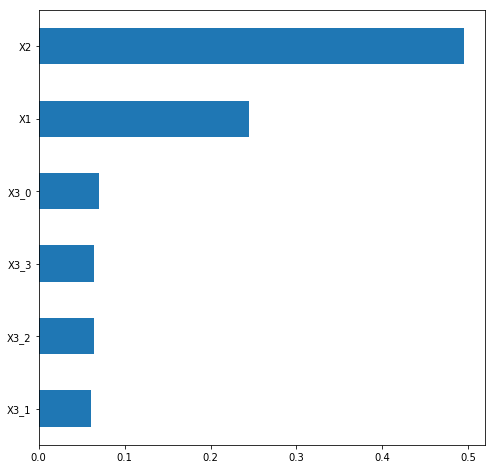

In [50]:
## Feature importance
all_new_columns = new_numerical_columns + new_low_card_columns

importance_df = pd.Series(xgb_model.feature_importances_, index=all_new_columns).sort_values(ascending=False).head(25)
plt.clf()
plt.figure(figsize=(8,8))
importance_df.sort_values(ascending=True).plot.barh()
plt.show()

In [51]:
print(np.sqrt(((train_data_modeling.error) ** 2).mean()))

296.5729650119655


##### Performance on validation dataset

In [52]:
prediction = xgb_model.predict(val_data_modeling_transformed)

In [53]:
val_data_modeling['TO_minute_pred'] = prediction
val_data_modeling['error'] = np.abs(val_data_modeling['TO_minute'] - val_data_modeling['TO_minute_pred'])
val_data_modeling.sort_values('error',ascending=True).head(400)

,id,X1,X2,X3,TO_minute,TO_minute_pred,error
76187,76301,-1.24,-0.21,1,835.000000,835.074829,0.074829
11386,11406,1.09,-3.80,1,847.500000,847.330261,0.169739
25079,25124,-1.32,0.88,3,708.000000,707.726624,0.273376
21688,21724,0.59,0.29,0,659.000000,659.424500,0.424500
93280,93414,1.98,-0.73,1,848.000000,847.535461,0.464539
12302,12323,0.07,4.20,3,660.500000,659.890320,0.609680
60530,60619,1.05,1.69,0,659.000000,658.225525,0.774475
33720,33776,-1.25,-1.24,3,762.000000,761.179504,0.820496
27416,27465,0.96,0.72,3,654.666667,655.616760,0.950094
89030,89159,-1.75,-1.46,0,767.500000,766.525146,0.974854


In [54]:
print(np.sqrt(((val_data_modeling.error) ** 2).mean()))

294.60010018528556


##### Performance on test dataset

In [55]:
prediction = xgb_model.predict(test_data_modeling_transformed)

In [56]:
test_data_modeling['TO_minute_pred'] = prediction
test_data_modeling['error'] = np.abs(test_data_modeling['TO_minute'] - test_data_modeling['TO_minute_pred'])
test_data_modeling.sort_values('error',ascending=True).head(400)

,id,X1,X2,X3,TO_minute,TO_minute_pred,error
77513,77627,0.01,1.67,1,676.000000,676.082153,0.082153
62606,62697,-1.49,-2.38,3,761.000000,761.199585,0.199585
77782,77896,1.27,-0.85,0,828.833333,829.085876,0.252543
20812,20845,1.47,-1.28,3,823.000000,822.732788,0.267212
85798,85924,0.32,-0.89,1,849.333333,848.674194,0.659139
7213,7227,0.06,-0.35,1,846.833333,846.029175,0.804159
69923,70026,0.84,-0.65,1,847.250000,848.059631,0.809631
26828,26876,0.68,-0.40,2,846.500000,847.475037,0.975037
39124,39186,0.45,0.91,1,678.500000,677.474243,1.025757
33281,33337,1.13,0.19,2,681.000000,679.915527,1.084473


In [57]:
print(np.sqrt(((test_data_modeling.error) ** 2).mean()))

296.370587219137


##### 6. Save files for package creation

In [58]:
## Saving data type for future incoming data points
from pairfinance.helper_functions.utils import dtype_mapping
dtype_mapping_output = dtype_mapping(numeric_columns=numerical_columns+low_cardinal_columns_before,
                              boolean_columns=[],
                              string_columns=[]
                             )
print(dtype_mapping_output)

{'X1': <class 'float'>, 'X2': <class 'float'>, 'X3': <class 'float'>}


In [59]:
from pairfinance.helper_functions.utils import check_input_data_type
import json

json_data = test_data_modeling.iloc[0].to_json()
print(json_data)
tt = pd.DataFrame.from_dict([json.loads(json_data)])

check_input_data_type(tt, dtype_mapping_output)

{"id":74545.0,"X1":-1.78,"X2":2.4,"X3":1.0,"TO_minute":520.0,"TO_minute_pred":779.7887573242,"error":259.7887573242}


In [60]:
import pickle 
all_files = selected_columns, numerical_columns, low_cardinal_columns_before, low_cardinal_columns_after, dtype_mapping_output, train_pipeline, xgb_model
with open('/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/pairfinance/pairfinance/model_files_v0.pkl','wb') as f:
    pickle.dump(all_files ,f)